# Text Classification using Neural Networks

## 1. Introduction

Text classification is the process of assigning tags or categories to text according to its content. It is an important process in Natural Language processing and Information Retrieval with broad applications in topic labelling and spam detection. Here I demonstrate how to use Machine Learning techniques to classify text. The problem we have is a binary classification problem, where we should assign text blocks to one category or the other. 

The problem is to classify whether a movie review, written by a critic is positive or negative. The dataset and techniques used for this problem are explained below with the results and discussion to follow.

## 2 The Dataset

The Dataset we are using is the IMDB Large Movie Review Dataset. This dataset consists of 25000 highly polar movie reviews for traiing and 25000 movie reviews for testing. We will use this dataset to train a binary classification model to predict whether the given review is positive or negative.

Keras provides a convinent way to import the dataset. All the reviews are tokenized and indexed to a number. Each review consists of a series of word indexes that range between 4 and 4999. Index 1 represents the start of a sentence. Index 2 represents unknown and out of vocabulary words. These indexes have been obtained by pre-processing the text data in a pipeline that cleans, normalizes and tokenizes each sentence first and then builds a dictionary indexing each of the tokens by frequency.

We shall start by importing the dataset and other essential libraries first.

In [2]:
import os
import string
import tempfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.keras.datasets import imdb
from tensorflow.python.keras.preprocessing import sequence
from tensorboard import summary as summary_lib

tf.logging.set_verbosity(tf.logging.INFO)

Then we shall proceed by loading the data. Since each sentence is of varying length, we shall pad zeros at the end of each sentence to get a 25000x200 matrix in both the training and testing sets.

In [3]:
vocab_size = 5000
sentence_size = 200
embedding_size = 50
model_dir = tempfile.mkdtemp()

# we assign the first indices in the vocabulary to special tokens that we use
# for padding, as start token, and for indicating unknown words
pad_id = 0
start_id = 1
oov_id = 2
index_offset = 2

print("Loading data...")
(x_train_variable, y_train), (x_test_variable, y_test) = imdb.load_data(
    num_words=vocab_size, start_char=start_id, oov_char=oov_id,
    index_from=index_offset)
print(len(y_train), "train sequences")
print(len(y_test), "test sequences")

print("Pad sequences (samples x time)")
x_train = sequence.pad_sequences(x_train_variable, 
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)
x_test = sequence.pad_sequences(x_test_variable, 
                                maxlen=sentence_size,
                                truncating='post',
                                padding='post', 
                                value=pad_id)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 200)
x_test shape: (25000, 200)


We shall use the word index to take a look at how a sample sentence is after padding, before we proceed with building a model.

In [4]:
word_index = imdb.get_word_index()
word_inverted_index = {v + index_offset: k for k, v in word_index.items()}

# The first indexes in the map are reserved to represent things other than tokens
word_inverted_index[pad_id] = '<PAD>'
word_inverted_index[start_id] = '<START>'
word_inverted_index[oov_id] = '<OOV>'
  
def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

print(index_to_text(x_train_variable[0]))

1646592/1641221 [==============================] - 0s 0us/step
<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <OOV> is an amazing actor and now the same being director <OOV> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <OOV> and would recommend it to everyone to watch and the fly <OOV> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <OOV> to the two little <OOV> that played the <OOV> of norman and paul they were just brilliant children are often left out of the <OOV> list i think because the stars that play them all grown up are such a big <OOV> for the whole film b

There's one more thing we need to do get our data ready for TensorFlow. We need to convert the data from numpy arrays into Tensors. Additionally, We define two input functions: one for processing the training data and one for processing the test data. We shuffle the training data and do not predefine the number of epochs we want to train, while we only need one epoch of the test data for evaluation. We also add an additional "len" key to both that captures the length of the original, unpadded sequence, which we will use later.

In [0]:
x_len_train = np.array([min(len(x), sentence_size) for x in x_train_variable])
x_len_test = np.array([min(len(x), sentence_size) for x in x_test_variable])

def parser(x, length, y):
    features = {"x": x, "len": length}
    return features, y

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_train, x_len_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(x_train_variable))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    dataset = dataset.repeat()
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_test, x_len_test, y_test))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

## 3. Linear Classifier

It's always a good practice to start any machine learning project trying out a couple of reliable baselines. Simple is always better and it is key to understand exactly how much we are gaining in terms of performance by adding extra complexity. So we shall start approaching this problem by building a basic linear classifier on the dataset.

In [6]:
column = tf.feature_column.categorical_column_with_identity('x', vocab_size)
classifier = tf.estimator.LinearClassifier(feature_columns=[column], 
                                           model_dir=os.path.join(model_dir, 'bow_sparse'),
                                           config=tf.estimator.RunConfig(log_step_count_steps=5000))

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpt078hbkc/bow_sparse', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 5000, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa4d4066f28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


We shall now write routines to train the classifier and evaluate it, which we can use for all the classifiers we are gonna build.

In [0]:
def train_classifier(classifier, steps=25000):
    tf.logging.set_verbosity(tf.logging.INFO)
    classifier.train(input_fn=train_input_fn, steps=steps)
    tf.logging.set_verbosity(tf.logging.ERROR)

def evaluate_classifier(classifier):
    eval_results = classifier.evaluate(input_fn=eval_input_fn)
    for result in eval_results:
      print(result,' : ',eval_results[result])

Now, we shall train our Linear Classifier on the training Data for 25000 steps and try evaluating it.

In [8]:
train_classifier(classifier)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpt078hbkc/

In [9]:
evaluate_classifier(classifier)

accuracy  :  0.81628
accuracy_baseline  :  0.5
auc  :  0.88860565
auc_precision_recall  :  0.8897927
average_loss  :  0.673751
label/mean  :  0.5
loss  :  67.3751
precision  :  0.8195264
prediction/mean  :  0.4949526
recall  :  0.8112
global_step  :  25000


Since this is a simpler model, we would be able to inspect the most important tokens, which have more weights in our model. The graph below shows such tokens.

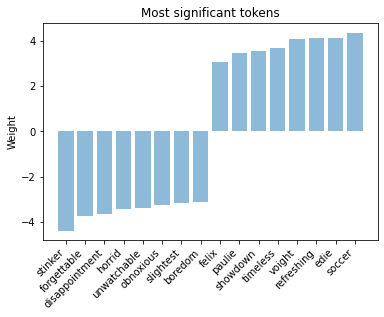

In [10]:
weights = classifier.get_variable_value('linear/linear_model/x/weights').flatten()
sorted_indexes = np.argsort(weights)
extremes = np.concatenate((sorted_indexes[-8:], sorted_indexes[:8]))
extreme_weights = sorted([(weights[i], word_inverted_index[i]) for i in extremes])

y_pos = np.arange(len(extreme_weights))
plt.bar(y_pos, [pair[0] for pair in extreme_weights], align='center', alpha=0.5)
plt.xticks(y_pos, [pair[1] for pair in extreme_weights], rotation=45, ha='right')
plt.ylabel('Weight')
plt.title('Most significant tokens') 
plt.show()

## 4. Neural Networks Classifier.

We saw that the linear classifier performed quite well on the dataset. We shall move ahead and try getting a better accuracy from other classifiers. To make the dataset more complex, we shall also try adding word embeddings. Embeddings are a dense low-dimensional representation of sparse high-dimensional data. This allows our model to learn a more meaningful representation of each token, rather than just an index. We can add word embeddings by converting our existing feature column into an embedding_column. The representation seen by the model is the mean of the embeddings for each token 

In [0]:
word_embedding_column = tf.feature_column.embedding_column(column, dimension=embedding_size)
neural_classifier = tf.estimator.DNNClassifier(
    hidden_units=[100],
    feature_columns=[word_embedding_column], 
    model_dir=os.path.join(model_dir, 'bow_embeddings'),
    config=tf.estimator.RunConfig(log_step_count_steps=5000))

In [12]:
train_classifier(neural_classifier)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpt078hbkc/bow_embeddings/model.ckpt.
INFO:tensorflow:loss = 69.34512, step = 1
INFO:tensorflow:global_step/sec: 133.614
INFO:tensorflow:loss = 16.770742, step = 5001 (37.426 sec)
INFO:tensorflow:global_step/sec: 138.552
INFO:tensorflow:loss = 3.8213756, step = 10001 (36.089 sec)
INFO:tensorflow:global_step/sec: 132.694
INFO:tensorflow:loss = 1.1921632, step = 15001 (37.678 sec)
INFO:tensorflow:global_step/sec: 131.668
INFO:tensorflow:loss = 0.54301333, step = 2000

Now we shall see how this new classifier fared against the Linear Classifier.

In [13]:
evaluate_classifier(classifier)

accuracy  :  0.81628
accuracy_baseline  :  0.5
auc  :  0.88860565
auc_precision_recall  :  0.8897927
average_loss  :  0.673751
label/mean  :  0.5
loss  :  67.3751
precision  :  0.8195264
prediction/mean  :  0.4949526
recall  :  0.8112
global_step  :  25000


## 5. Connvolutional Neural Networks

We saw that neural network had a better accuracy than the linear classifier. We shall make our model more complex by building convlutional neural networks for this problem. Convolutions are one way to take advantage of this structure, similar to how we can model salient clusters of pixels for image classification. The intuition is that certain sequences of words, or n-grams, usually have the same meaning regardless of their overall position in the sentence. Introducing a structural prior via the convolution operation allows us to model the interaction between neighboring words and consequently gives us a better way to represent such meaning.

In [0]:
head = tf.contrib.estimator.binary_classification_head()

def cnn_model_fn(features, labels, mode, params):    
    input_layer = tf.contrib.layers.embed_sequence(
        features['x'], vocab_size, embedding_size,
        initializer=params['embedding_initializer'])
    
    training = mode == tf.estimator.ModeKeys.TRAIN
    dropout_emb = tf.layers.dropout(inputs=input_layer, 
                                    rate=0.2, 
                                    training=training)

    conv = tf.layers.conv1d(
        inputs=dropout_emb,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    pool = tf.reduce_max(input_tensor=conv, axis=1)
    
    hidden = tf.layers.dense(inputs=pool, units=250, activation=tf.nn.relu)
    
    dropout_hidden = tf.layers.dropout(inputs=hidden, 
                                       rate=0.2, 
                                       training=training)
    
    logits = tf.layers.dense(inputs=dropout_hidden, units=1)
    
    if labels is not None:
        labels = tf.reshape(labels, [-1, 1])
        

    optimizer = tf.train.AdamOptimizer()
    
    def _train_op_fn(loss):
        return optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

    return head.create_estimator_spec(
        features=features,
        labels=labels,
        mode=mode,
        logits=logits, 
        train_op_fn=_train_op_fn)

Now that we have written the classifier object, we shall proceed by intializing an instance of the classifier and passing it to the training function.

In [19]:
params = {'embedding_initializer': tf.random_uniform_initializer(-1.0, 1.0)}
cnn_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,
                                        model_dir=os.path.join(model_dir, 'cnn'),
                                        params=params,
                                        config=tf.estimator.RunConfig(log_step_count_steps=5000))
train_classifier(cnn_classifier)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpt078hbkc/cnn/model.ckpt.
INFO:tensorflow:loss = 0.99569696, step = 1
INFO:tensorflow:global_step/sec: 20.5512
INFO:tensorflow:loss = 0.09419124, step = 5001 (243.299 sec)
INFO:tensorflow:global_step/sec: 20.7033
INFO:tensorflow:loss = 0.04770914, step = 10001 (241.507 sec)
INFO:tensorflow:Saving checkpoints for 12359 into /tmp/tmpt078hbkc/cnn/model.ckpt.
INFO:tensorflow:global_step/sec: 20.4608
INFO:tensorflow:loss = 0.04602832, step = 15001 (244.369 sec)
INFO:tensorflow:global_step/sec: 20.6281
INFO:tensorflow:loss = 0.013398403, step = 20001 (242.391 sec)
INFO:tensorflow:Sav

In [20]:
evaluate_classifier(cnn_classifier)

accuracy  :  0.84596
accuracy_baseline  :  0.5
auc  :  0.9012032
auc_precision_recall  :  0.9104663
average_loss  :  0.86630476
label/mean  :  0.5
loss  :  0.86630476
precision  :  0.8429693
prediction/mean  :  0.503754
recall  :  0.85032
global_step  :  25000


## 6 LSTM Network

In our efforts to get even better accuracy on the dataset, we shall try building a Long Short-Term Memory (LSTM) cells Network. An LSTM processes the entire document sequentially, recursing over the sequence with its cell while storing the current state of the sequence in its memory. LSTM is a Recurrent Neural Network (RNN). One of the drawbacks of recurrent models is that, because of the nature of recursion, models are deeper and more complex, which usually results in slower training time and worse convergence. LSTMs can suffer convergence issues like vanishing or exploding gradients.

In the beginning, we padded all documents up to 200 tokens, which is necessary to build a proper tensor. However, when a document contains fewer than 200 words, we don't want the LSTM to continue processing padding tokens as it does not add information and degrades performance. For this reason, we additionally want to provide our network with the length of the original sequence before it was padded.

In [0]:
head = tf.contrib.estimator.binary_classification_head()

def lstm_model_fn(features, labels, mode):    
    # [batch_size x sentence_size x embedding_size]
    inputs = tf.contrib.layers.embed_sequence(
        features['x'], vocab_size, embedding_size,
        initializer=tf.random_uniform_initializer(-1.0, 1.0))

    # create an LSTM cell of size 100
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(100)
    
    # create the complete LSTM
    _, final_states = tf.nn.dynamic_rnn(
        lstm_cell, inputs, sequence_length=features['len'], dtype=tf.float32)

    # get the final hidden states of dimensionality [batch_size x sentence_size]
    outputs = final_states.h

    logits = tf.layers.dense(inputs=outputs, units=1)

    if labels is not None:
        labels = tf.reshape(labels, [-1, 1])

    optimizer = tf.train.AdamOptimizer()

    def _train_op_fn(loss):
        return optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

    return head.create_estimator_spec(
        features=features,
        labels=labels,
        mode=mode,
        logits=logits,
        train_op_fn=_train_op_fn)

In [0]:
lstm_classifier = tf.estimator.Estimator(model_fn=lstm_model_fn,
                                         model_dir=os.path.join(model_dir, 'lstm'))

In [16]:
train_classifier(lstm_classifier)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpt078hbkc/lstm/model.ckpt.
INFO:tensorflow:loss = 0.7076198, step = 1
INFO:tensorflow:global_step/sec: 2.47515
INFO:tensorflow:loss = 0.7425122, step = 101 (40.407 sec)
INFO:tensorflow:global_step/sec: 2.48924
INFO:tensorflow:loss = 0.54

In [17]:
evaluate_classifier(lstm_classifier)

accuracy  :  0.83924
accuracy_baseline  :  0.5
auc  :  0.85572875
auc_precision_recall  :  0.88701934
average_loss  :  2.7127547
label/mean  :  0.5
loss  :  2.7127552
precision  :  0.8427775
prediction/mean  :  0.49515826
recall  :  0.83408
global_step  :  25000


## 7. Discussion

We can see that the CNNs and LSTM work well with the dataset. Due to limitations in computing, I was not able to train these networks for longer period. With more training, these models might perform even better. Now, we are getting an accuracy of closer to 85%, which is really great considering the size of the dataset. Similarly, we can also perform multiclass classification using these neural networks.